#**Script to simulate data for one of the species in the Kirschner et al. (2022) Nat. Comm. paper.** 

in order to use this code you have to have ms installed on your computer
ms can be freely downloaded from:
http://home.uchicago.edu/rhudson1/source/mksamples.html

First, download ms to your Colab.

In [42]:
!gdown 1A8eXKbmumSF_DkhK4xjUF5R7J5ERZUvy

#Change permissions for the ms file
chmod="chmod 777 /content/ms"
!{chmod}

Downloading...
From: https://drive.google.com/uc?id=1A8eXKbmumSF_DkhK4xjUF5R7J5ERZUvy
To: /content/ms
100% 52.9k/52.9k [00:00<00:00, 60.9MB/s]


In [43]:
mscommand="/content/ms "
!{mscommand}

Too few command line arguments
usage: ms nsam howmany 
  Options: 
	 -t theta   (this option and/or the next must be used. Theta = 4*N0*u )
	 -s segsites   ( fixed number of segregating sites)
	 -T          (Output gene tree.)
	 -F minfreq     Output only sites with freq of minor allele >= minfreq.
	 -r rho nsites     (rho here is 4Nc)
		 -c f track_len   (f = ratio of conversion rate to rec rate. tracklen is mean length.) 
			 if rho = 0.,  f = 4*N0*g, with g the gene conversion rate.
	 -G alpha  ( N(t) = N0*exp(-alpha*t) .  alpha = -log(Np/Nr)/t
	 -I npop n1 n2 ... [mig_rate] (all elements of mig matrix set to mig_rate/(npop-1) 
		 -m i j m_ij    (i,j-th element of mig matrix set to m_ij.)
		 -ma m_11 m_12 m_13 m_21 m_22 m_23 ...(Assign values to elements of migration matrix.)
		 -n i size_i   (popi has size set to size_i*N0 
		 -g i alpha_i  (If used must appear after -M option.)
	   The following options modify parameters at the time 't' specified as the first argument:
	 -eG t alp

In [44]:
#If you want convert to sequences you can use seq-gen.
mscommand="/content/ms 5 1 -t 5 -T"
!{mscommand}

/content/ms 5 1 -t 5 -T 
37556 47363 19421

//
(2:1.136,(1:0.354,(5:0.225,(3:0.175,4:0.175):0.050):0.128):0.782);
segsites: 16
positions: 0.0186 0.0436 0.0693 0.1641 0.1958 0.1975 0.3005 0.4086 0.4614 0.5474 0.5903 0.6183 0.6976 0.8729 0.9762 0.9897 
1100000011001010
0001101000100100
0000010011000011
0000010111000010
0010000011010010


In [54]:
mscommand="/content/ms 5 1000 -t 5 -s 1 -T"
!{mscommand}

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
positions: 0.5231 
1
0
0
0
0

//
((3:0.035,(1:0.000,2:0.000):0.034):0.205,(4:0.092,5:0.092):0.148);
prob: 0.145646
segsites: 1
positions: 0.9577 
0
0
0
1
0

//
((2:0.170,4:0.170):0.752,(3:0.177,(1:0.067,5:0.067):0.111):0.745);
prob: 0.000140577
segsites: 1
positions: 0.6621 
0
1
0
0
0

//
(3:0.510,(4:0.167,(5:0.162,(1:0.147,2:0.147):0.015):0.005):0.343);
prob: 0.00421891
segsites: 1
positions: 0.8741 
0
0
0
0
1

//
(4:1.587,(5:0.314,(2:0.229,(1:0.001,3:0.001):0.228):0.085):1.273);
prob: 1.56069e-07
segsites: 1
positions: 0.9964 
1
1
1
0
1

//
((2:0.307,3:0.307):1.128,(1:0.899,(4:0.160,5:0.160):0.739):0.536);
prob: 1.34165e-08
segsites: 1
positions: 0.8931 
1
0
0
0
0

//
(5:1.369,((2:0.005,3:0.005):0.126,(1:0.035,4:0.035):0.096):1.238);
prob: 6.98946e-06
segsites: 1
positions: 0.8780 
0
0
0
0
1

//
((1:0.037,(2:0.016,5:0.016):0.021):0.531,(3:0.248,4:0.248):0.320);
prob: 0.00540904
segsites: 1
positions: 0.8498

Now, import all requided modules and define useful functions.

In [46]:
## import all required modules.
import random
import os
import math
import shlex, subprocess
import numpy as np

##define a function to read ms' simulations and transform then into a NumPy array. I updated this function because the 0 and 1 genotypes were being converted to 48 and 49.  
def ms2nparray(xfile):
	g = list(xfile)
	k = [idx for idx,i in enumerate(g) if len(i) > 0 and i.startswith(b'//')]
	f = []
	for i in k:
		L = g[i+4:i+nDNANsam+4]
		q = []
		for i in L:
			i = i = [int(j) for j in list(i.decode('utf-8'))]
			i = np.array(i)
			q.append(i)
		q = np.array(q)
		q = q.astype("int8")
		f.append(np.array(q))
	return f

Declare all global variables that will be used for all scenarios.

In [47]:
### variable declarations.

#define the number of simulations. I am using a low number so that we can simulate fast. I shoul use 10,000 simulations at least
Priorsize = 10

## sample size for Extrazonal.
nExZ = 160
## sample size for Zonal.
nZ = 110
## Combines sample size.
nDNANsam = nExZ + nZ

##mutation rate.
mutrate = 7.0E-9

#Add one variable for each model.
simModel1 = []
simModel2 = []
simModel3 = []

Start a loop for scenario 1. Inside this loop the priors should be sampled from their distributions and added to the ms command. Save the sampled parameter values for each simulation.

In [48]:
### Cold stage expansion, with migration until LGM.
for i in range(Priorsize):

	### Define parameters.
	## number of years per generation.
	genlen = random.uniform(8,10)
	##Ne from 40k to 200k.
	Ne = random.uniform(40000,200000)
	##Ne proportion for the Zonal lineage.
	NeZ=random.uniform(0.2,5)
	## Calculate theta values. My read were 85 bp long.
	Theta = 4*Ne*mutrate*85
	#relative values of Ne fro each period.
	NeExZLGM=random.uniform(5,100)
	NeZLGM=random.uniform(5,100)
	NeExZPl=random.uniform(0.5,1)
	NeZPl=random.uniform(0.5,1)
	
	## divergence time prior in years, following uniform distributions.
	T3=random.uniform(0,12000)
	T2=random.uniform(12000,110000)
	T1Growth=random.uniform(110000,500000)
	T1=random.uniform(T1Growth,2400000)

	## Transform to coalescent units.
	coalT3=T3/(genlen*4.0*Ne)
	coalT2=T2/(genlen*4.0*Ne)
	coalT1Growth=T1Growth/(genlen*4.0*Ne)
	coalT1=T1/(genlen*4.0*Ne)

	# calculate growth rates from time and magnitude of the expansion.
	GrowthExZ = -(1/(coalT1Growth-coalT2))*math.log(NeExZPl/NeExZLGM)
	GrowthZ = -(1/(coalT1Growth-coalT2))*math.log(NeZPl/NeZLGM)

	## migration prior set to 0 in this model.
	m12_Pres=0
	m21_Pres=0
	m12_LGM=random.uniform(0,5)
	m21_LGM=random.uniform(0,5)
	m12_Pl=random.uniform(0,5)
	m21_Pl=random.uniform(0,5)
	
	# simulate SNPs.
	com=subprocess.Popen("/content/ms %d 1000 -s 1 -t %f -I 2 %d %d -n 2 %f -en %f 1 %f -en %f 2 %f -em %f 1 2 %f -em %f 2 1 %f -eg %f 1 %f -eg %f 2 %f -em %f 1 2 %f -em %f 2 1 %f -eg %f 1 0 -eg %f 2 0 -ej %f 1 2" % (nDNANsam, Theta, nExZ, nZ, NeZ, coalT3, NeExZLGM, coalT3, NeZLGM, coalT3, m12_LGM, coalT3, m21_LGM, coalT2, GrowthExZ, coalT2, GrowthZ, coalT2, m12_Pl, coalT2, m21_Pl, coalT1Growth, coalT1Growth, coalT1), shell=True, stdout=subprocess.PIPE).stdout
	output = com.read().splitlines()
	simModel1.append(np.array(ms2nparray(output)).swapaxes(0,1).reshape(nDNANsam,-1).T)
	
	## save parameter values.
	with open('/content/parameters1.txt', 'a') as parameters1:
		parameters1.write("%f\t%f\t%f\t%f\t%f\t%f\t%f\t%f\t%f\t%f\t%f\t%f\t%f\t%f\t%f\t%f\n" % (Theta, T1, T2, T3, Ne, NeZ, NeExZLGM, NeZLGM, NeExZPl, NeZPl, m12_Pres, m21_Pres, m12_LGM, m21_LGM, m12_Pl, m21_Pl))

Save the simulated genetic data as NumPy arrays to be used for Deep Learning model comparison afterwards.

In [49]:
#save NumPy arrays.
simModel1=np.array(simModel1)
np.save('simModel1.npy', simModel1)

#You can visualize the arrays
simModel1

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 1, 1, 1],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 1, 0, 1],
        ...,
        [0, 0, 0, ..., 

In [50]:
#You can also check if their shape is correct 
simModel1.shape

(10, 1000, 270)

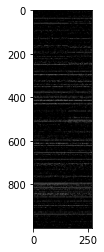

In [51]:
#and visualize some images
import matplotlib.pyplot as plt
plt.imshow(simModel1[0],cmap='gray', vmin=0, vmax=1)

Repeat the same steps for the other scenarios.

In [52]:
#remove the simulations from memro, to free RAM.
del(simModel1)

## Cold stage expansion only in Z, with migration until LGM.
for i in range(Priorsize):

	### Define parameters.
	## number of years per generation.
	genlen = random.uniform(8,10)
	##Ne from 40k to 200k.
	Ne = random.uniform(40000,200000)
	##Ne proportion for the Zonal lineage.
	NeZ=random.uniform(0.2,5)
	## Calculate theta values.
	Theta = 4*Ne*mutrate*85
	#relative values of Ne for each period.
	NeExZLGM=1
	NeZLGM=random.uniform(5,100)
	NeExZPl=1
	NeZPl=random.uniform(0.5,1)
	
	## divergence time prior in years, following uniform distributions.
	T3=random.uniform(0,12000)
	T2=random.uniform(12000,110000)
	T1Growth=random.uniform(110000,500000)
	T1=random.uniform(T1Growth,2400000)

	## Transform to coalescent units.
	coalT3=T3/(genlen*4.0*Ne)
	coalT2=T2/(genlen*4.0*Ne)
	coalT1Growth=T1Growth/(genlen*4.0*Ne)
	coalT1=T1/(genlen*4.0*Ne)
	
	# calculate growth rates from time and magnitude of the expansion.
	GrowthZ = -(1/(coalT1Growth-coalT2))*math.log(NeZPl/NeZLGM)

	## migration prior set to 0 in this model.
	m12_Pres=0
	m21_Pres=0
	m12_LGM=random.uniform(0,5)
	m21_LGM=random.uniform(0,5)
	m12_Pl=random.uniform(0,5)
	m21_Pl=random.uniform(0,5)
	
	## simulate SNPs.
	com=subprocess.Popen("/content/ms %d 1000 -s 1 -t %f -I 2 %d %d -n 2 %f -en %f 2 %f -em %f 1 2 %f -em %f 2 1 %f -eg %f 2 %f -em %f 1 2 %f -em %f 2 1 %f -eg %f 2 0 -ej %f 1 2" % (nDNANsam, Theta, nExZ, nZ, NeZ, coalT3, NeZLGM, coalT3, m12_LGM, coalT3, m21_LGM, coalT2, GrowthZ, coalT2, m12_Pl, coalT2, m21_Pl, coalT1Growth, coalT1), shell=True, stdout=subprocess.PIPE).stdout
	output = com.read().splitlines()
	simModel2.append(np.array(ms2nparray(output)).swapaxes(0,1).reshape(nDNANsam,-1).T)
	
	## save parameter values.
	with open('/content/parameters2.txt', 'a') as parameters2:
		parameters2.write("%f\t%f\t%f\t%f\t%f\t%f\t%f\t%f\t%f\t%f\t%f\t%f\t%f\t%f\t%f\t%f\n" % (Theta, T1, T2, T3, Ne, NeZ, NeExZLGM, NeZLGM, NeExZPl, NeZPl, m12_Pres, m21_Pres, m12_LGM, m21_LGM, m12_Pl, m21_Pl))

#save NumPy arrays.
simModel2=np.array(simModel2)
np.save('simModel2.npy', simModel2)
del(simModel2)

### Stable pop sizes model, with migration until LGM.
for i in range(Priorsize):

	### Define parameters.
	## number of years per generation.
	genlen = random.uniform(8,10)
	##Ne from 40k to 200k.
	Ne = random.uniform(40000,200000)
	##Ne proportion for the Zonal lineage.
	NeZ=random.uniform(0.2,5)
	## Calculate theta values.
	Theta = 4*Ne*mutrate*85
	#relative values of Ne fro each period.
	NeExZLGM=1
	NeZLGM=1
	NeExZPl=1
	NeZPl=1
	
	## divergence time prior in years, following uniform distributions.
	T3=random.uniform(0,12000)
	T2=random.uniform(12000,110000)
	T1=random.uniform(110000,2400000)

	## Transform to coalescent units.
	coalT3=T3/(genlen*4.0*Ne)
	coalT2=T2/(genlen*4.0*Ne)
	coalT1=T1/(genlen*4.0*Ne)

	## migration prior set to 0 in this model.
	m12_Pres=0
	m21_Pres=0
	m12_LGM=random.uniform(0,5)
	m21_LGM=random.uniform(0,5)
	m12_Pl=random.uniform(0,5)
	m21_Pl=random.uniform(0,5)
	
	## simulate SNPs.
	com=subprocess.Popen("/content/ms %d 1000 -s 1 -t %f -I 2 %d %d -n 2 %f -em %f 1 2 %f -em %f 2 1 %f -em %f 1 2 %f -em %f 2 1 %f -ej %f 1 2" % (nDNANsam, Theta, nExZ, nZ, NeZ, coalT3, m12_LGM, coalT3, m21_LGM, coalT2, m12_Pl, coalT2, m21_Pl, coalT1), shell=True, stdout=subprocess.PIPE).stdout
	output = com.read().splitlines()
	simModel3.append(np.array(ms2nparray(output)).swapaxes(0,1).reshape(nDNANsam,-1).T)
	
	## save parameter values.
	with open('/content/parameters3.txt', 'a') as parameters3:
		parameters3.write("%f\t%f\t%f\t%f\t%f\t%f\t%f\t%f\t%f\t%f\t%f\t%f\t%f\t%f\t%f\t%f\n" % (Theta, T1, T2, T3, Ne, NeZ, NeExZLGM, NeZLGM, NeExZPl, NeZPl, m12_Pres, m21_Pres, m12_LGM, m21_LGM, m12_Pl, m21_Pl))

#save NumPy arrays.
simModel3=np.array(simModel3)
np.save('simModel3.npy', simModel3)
del(simModel3)